## Video Processing

_Aim:_ Use some basic video/image processing techniques to extract useful information.

In [1]:
import skvideo.io
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [83]:
def get_video_stats(day, hour, bin_size):
    metadata = skvideo.io.ffprobe(os.path.join('D:', 'rat-video', 'day{:d}', 'hour{:d}.mp4').format(day, hour))
    videogen = skvideo.io.vreader(os.path.join('D:', 'rat-video', 'day{:d}', 'hour{:d}.mp4').format(day, hour), as_grey=True)
    pw_sum = np.zeros((3600 // bin_size, int(metadata['video']['@height']), int(metadata['video']['@width'])), dtype=np.uint)
    pw_sum_sq = np.zeros((3600 // bin_size, int(metadata['video']['@height']), int(metadata['video']['@width'])), dtype=np.uint)
    frame_sq = np.empty((int(metadata['video']['@height']), int(metadata['video']['@width'])), dtype=np.uint)
    tvn = np.zeros(4000 * 15 // bin_size, dtype=np.float64)
    frame_count = 0
    bin_count = 0
    for frame in videogen:
        temp_frame = np.uint(frame.squeeze())
        if frame_count > 0:
            np.subtract(temp_frame, prev_frame, out=prev_frame)
            np.abs(prev_frame, out=prev_frame)
            tvn[frame_count // (bin_size * 15)] += np.float64(np.sum(prev_frame)) / (np.float64(255 * int(metadata['video']['@height']) * int(metadata['video']['@width'])) * bin_size * 15)
            
        pw_sum[bin_count, :, :] += temp_frame
        np.square(temp_frame, out=frame_sq)
        pw_sum_sq[bin_count, :, :] += frame_sq
        prev_frame = temp_frame
        frame_count += 1
        if frame_count % (bin_size * 15) == 0:
            bin_count += 1
    pw_mean = pw_sum / (bin_size * 15)
    pw_std = np.sqrt(np.abs(pw_sum_sq / (bin_size * 15) - np.square(pw_mean)))
    tvn = tvn[0:60]
    return pw_mean, pw_std, tvn

In [15]:
with np.load(os.path.join('D:\\', 'rat-video', 'video_stats_day1.npz')) as dataz:
    pw_mean = dataz['pw_mean']
    pw_std = dataz['pw_std']
    tvn = dataz['tvn']

In [21]:
skvideo.io.vwrite('std-24.mp4', pw_std)

TypeError: Invalid shape (60, 480, 640) for image data

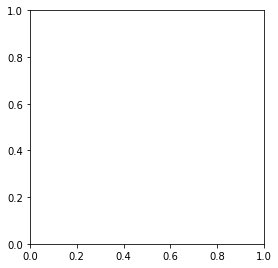

In [16]:
fig = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(2, 4, wspace=0.1, hspace=0.1)
ax1 = fig.add_subplot(grid[0, 0])
ax1.imshow(pw_std[0, :, :])
ax1.set_xticks([])
ax1.set_yticks([])
ax2 = fig.add_subplot(grid[0, 1])
ax2.imshow(pw_std[15, :, :])
ax2.set_xticks([])
ax2.set_yticks([])
ax3 = fig.add_subplot(grid[0, 2])
ax3.imshow(pw_std[30, :, :])
ax3.set_xticks([])
ax3.set_yticks([])
ax4 = fig.add_subplot(grid[0, 3])
ax4.imshow(pw_std[45, :, :])
ax4.set_xticks([])
ax4.set_yticks([])
ax5 = fig.add_subplot(grid[1, :])
ax5.plot(tvn)
ax5.set_title('Total Variation Norm')
c = ax5.set_xlabel('Bins')

In [86]:
np.savez('video_stats', pw_mean=pw_mean, pw_std=pw_std, tvn=tvn)